<a href="https://colab.research.google.com/github/RanxduG/Sri-Lanka-Formaldehyde-Level-Analysis/blob/main/Colombo_Monthly_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Libraries**

In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Colombo_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data Engineering Coursework/Full/colombo_joined_data.csv')

#**Preparing Data**

In [4]:
Colombo_data.rename(columns={'HCHO reading': 'HCHO_reading'}, inplace=True)

In [6]:
features = ['HCHO_reading', 'RH2M', 'WD10M', 'QV2M', 'WS10M', 'TS', 'PS', 'PRECTOTCORR', 'date']
Colombo_selected = Colombo_data[features]

In [7]:
Colombo_selected['date'] = pd.to_datetime(Colombo_selected['date'])
Colombo_selected = Colombo_selected.set_index('date')

<ipython-input-7-cda9ce004e8b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Colombo_selected['date'] = pd.to_datetime(Colombo_selected['date'])


In [8]:
Colombo_selected

,HCHO_reading,RH2M,WD10M,QV2M,WS10M,TS,PS,PRECTOTCORR
date,,,,,,,,
2019-01-01,0.000197,80.00,35.50,15.62,6.29,25.29,100.03,0.12
2019-01-02,0.000263,79.50,33.44,15.14,5.64,25.01,100.02,0.02
2019-01-03,0.000099,78.50,30.62,14.77,6.15,24.73,100.06,0.01
2019-01-04,0.000210,77.62,34.25,14.47,5.64,24.57,100.01,0.00
2019-01-05,0.000179,81.50,71.81,16.05,5.47,25.33,99.88,0.03
...,...,...,...,...,...,...,...,...
2023-12-27,0.000118,87.50,28.00,19.71,5.91,27.06,99.66,3.22
2023-12-28,0.000178,89.06,55.75,20.26,3.70,27.19,99.60,12.37
2023-12-29,0.000178,86.62,45.00,19.53,2.95,27.12,99.69,7.40


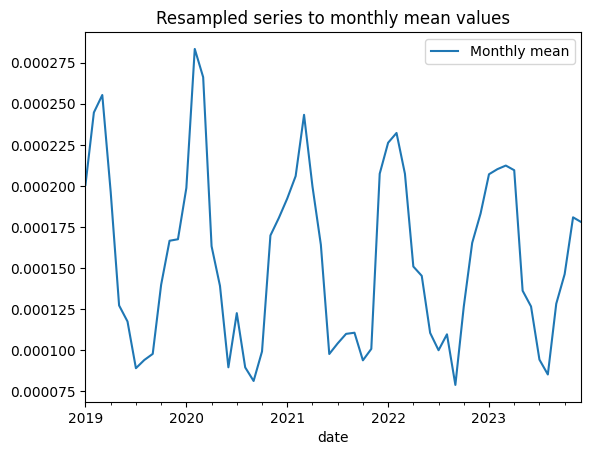

In [98]:
resample = Colombo_selected.resample('M')
colombo_monthly_mean = resample.mean()
colombo_monthly_mean.HCHO_reading.plot(label='Monthly mean')
plt.title("Resampled series to monthly mean values")
plt.legend()

#**Performing ADF test, ACF & PACF**

In [73]:
from statsmodels.tsa.stattools import adfuller

X = colombo_monthly_mean.HCHO_reading.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.091034
p-value: 0.000000
Critical Values:
	1%: -3.566
	5%: -2.920
	10%: -2.598


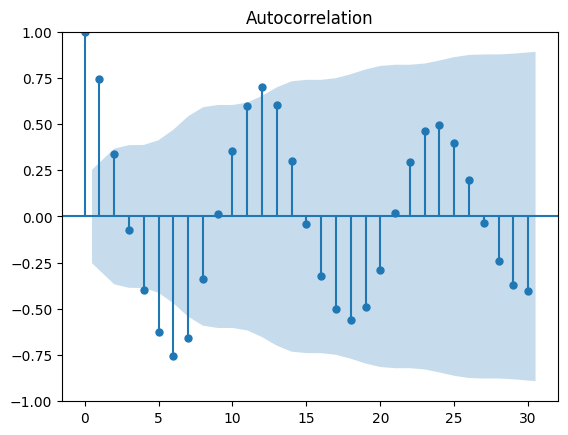

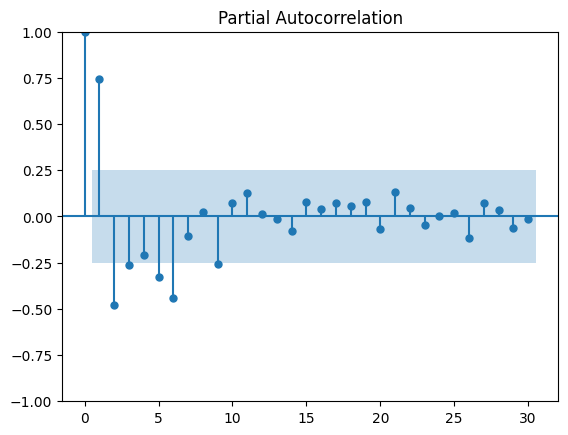

In [74]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
series = colombo_monthly_mean.HCHO_reading.values
plot_acf(series, lags=30)
plot_pacf(series, lags=30)
plt.show()

#**Spliting train and test data**

In [75]:
split_index = int(len(colombo_monthly_mean) * 0.8)

# Splitting the data into training and test sets
train_data = colombo_monthly_mean.iloc[:split_index]
test_data = colombo_monthly_mean.iloc[split_index:]

print("Length of training set:", len(train_data))
print("Length of test set:", len(test_data))



Length of training set: 48
Length of test set: 12


#**Univariable ARIMA**

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data['HCHO_reading'], order=(3,1,2))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
from sklearn.metrics import mean_squared_error
forecast = model_fit.forecast(steps=len(test_data['HCHO_reading']))
print(forecast)

mse = mean_squared_error(test_data['HCHO_reading'], forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test_data['HCHO_reading'], label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()

#**Univariable SARIMAX**

In [95]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# # SARIMA modeling (continued from original code)
order = (2, 0, 1)  # Non-seasonal parameters
seasonal_order = (2, 0, 1, 12)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Fit SARIMA model
model = SARIMAX(train_data['HCHO_reading'], order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test_data['HCHO_reading']))
# print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


MSE: 9.02444678774308e-10
RMSE: 3.0040717014983313e-05


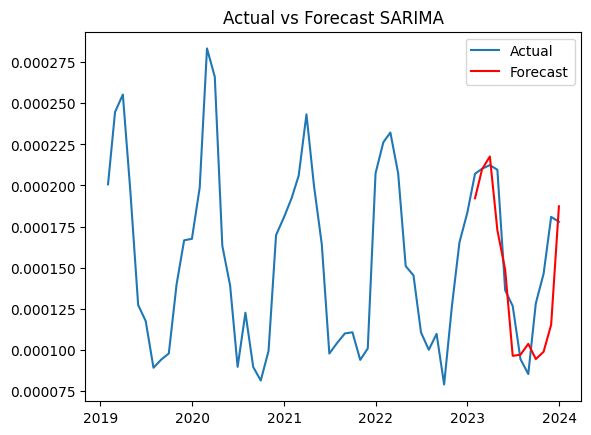

In [99]:
# Calculate MSE and RMSE
mse = mean_squared_error(test_data['HCHO_reading'], forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(colombo_monthly_mean['HCHO_reading'], label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

#**Multivariable SARIMAX**

In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA modeling
order = (2, 0, 1)  # Non-seasonal parameters
seasonal_order = (2, 0, 1, 12)  # Seasonal parameters, assuming a yearly seasonal pattern

# Combine exogenous variables
exog_cols = ['RH2M', 'WD10M', 'QV2M', 'WS10M', 'TS', 'PS', 'PRECTOTCORR']
exog_data = train_data[exog_cols]  # Assuming train_data is your DataFrame containing all variables
exog_data_test = test_data[exog_cols]  # Assuming test_data is your DataFrame containing all variables

# Fit SARIMAX model with exogenous variables
model = SARIMAX(train_data['HCHO_reading'], exog=exog_data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test_data['HCHO_reading']), exog=exog_data_test)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE: 3.5192812018876923e-10
RMSE: 1.875974733808452e-05


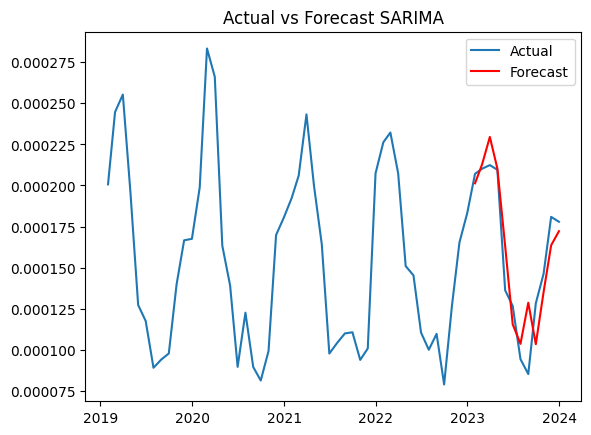

In [105]:
# Calculate MSE and RMSE
mse = mean_squared_error(test_data['HCHO_reading'], forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(colombo_monthly_mean['HCHO_reading'], label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

#LSTM